In [103]:
using SymbolicNumericIntegration
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using DoubleFloats

In [120]:
@variables ϵ r x₁ x₂ ;

#ϕ = exp(-r^2*ϵ^2)
#ϕ = (1.0-r*ϵ)^8 * (32.0*(r*ϵ)^3 + 25.0* (r*ϵ)^2 + 8.0*r*ϵ + 1.0)
ϕ = r^5
#ϕ = (1-r*ϵ)^4 * (4r*ϵ+1)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))
ϕ = simplify(ϕ,expand = true)
#display(ϕ)  
#Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₁/r),expand = true)
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)) + expand_derivatives(Differential(r)(exprs)) * (x₂/r),expand = true)
Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))


Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ])
#Φ_div = substitute.(Φ_div,r=>sqrt(x₁^2 + x₂^2))

#Φ_div = substitute.([ϕ 0.0 ; 0.0 ϕ],r=>sqrt(x₁^2 + x₂^2))
λ1(x) = x
λ2(x) = ∂₁(∂₁(x)) + ∂₂(∂₂(x))
λ3(x) = ∂₁(∂₁(x)) + ∂₁(x)
phi = eval(build_function(substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)), [x₁, x₂], ϵ))

#display(Φ_div)
#phi([0,0],10)

K = construct_kernel_array(ϕ,[λ2,λ1],[λ2,λ1])
display(K)
K = compile_kernel_array(K)

KE = construct_kernel_array(ϕ,[λ1],[λ2,λ1])
display(KE)
KE = compile_kernel_array(KE)
println(K[1,1]([1e-30,1e-30],0))


P_list1D = generate_2D1_poly_basis(3)
display(P_list1D)
F_P = apply_functionals_to_polynomials([λ2,λ1],P_list1D)
display(F_P)
F_P = compile_polynomials(F_P)

F_PE = apply_functionals_to_polynomials([λ1],P_list1D)
display(F_PE)
F_PE = compile_polynomials(F_PE)

N_poly = size(F_P)[2]


2×2 Matrix{Num}:
 (120//1)*sqrt(x₁^2 + x₂^2) + (120//1)*(x₁^2)*(sqrt(x₁^2 + x₂^2)^-1) + (120//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1) - (15//1)*(x₁^4)*(sqrt(x₁^2 + x₂^2)^-3) - (15//1)*(x₂^4)*(sqrt(x₁^2 + x₂^2)^-3) - (30//1)*(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-3)  …  (10//1)*(sqrt(x₁^2 + x₂^2)^3) + (15//1)*(x₁^2)*sqrt(x₁^2 + x₂^2) + (15//1)*(x₂^2)*sqrt(x₁^2 + x₂^2)
                                                                                                                                         (10//1)*(sqrt(x₁^2 + x₂^2)^3) + (15//1)*(x₁^2)*sqrt(x₁^2 + x₂^2) + (15//1)*(x₂^2)*sqrt(x₁^2 + x₂^2)                                                                                     sqrt(x₁^2 + x₂^2)^5

1×2 Matrix{Num}:
 (10//1)*(sqrt(x₁^2 + x₂^2)^3) + (15//1)*(x₁^2)*sqrt(x₁^2 + x₂^2) + (15//1)*(x₂^2)*sqrt(x₁^2 + x₂^2)  …  sqrt(x₁^2 + x₂^2)^5

3.181980515339464e-28


10-element Vector{Any}:
         1.0
        x₂
        x₁
      x₂^2
     x₁*x₂
      x₁^2
      x₂^3
 x₁*(x₂^2)
 x₂*(x₁^2)
      x₁^3

2×10 Matrix{Num}:
 0     0   0     2      0     2   6x₂        2x₁        2x₂   6x₁
 1.0  x₂  x₁  x₂^2  x₁*x₂  x₁^2  x₂^3  x₁*(x₂^2)  x₂*(x₁^2)  x₁^3

1×10 Matrix{Num}:
 1.0  x₂  x₁  x₂^2  x₁*x₂  x₁^2  x₂^3  x₁*(x₂^2)  x₂*(x₁^2)  x₁^3

10

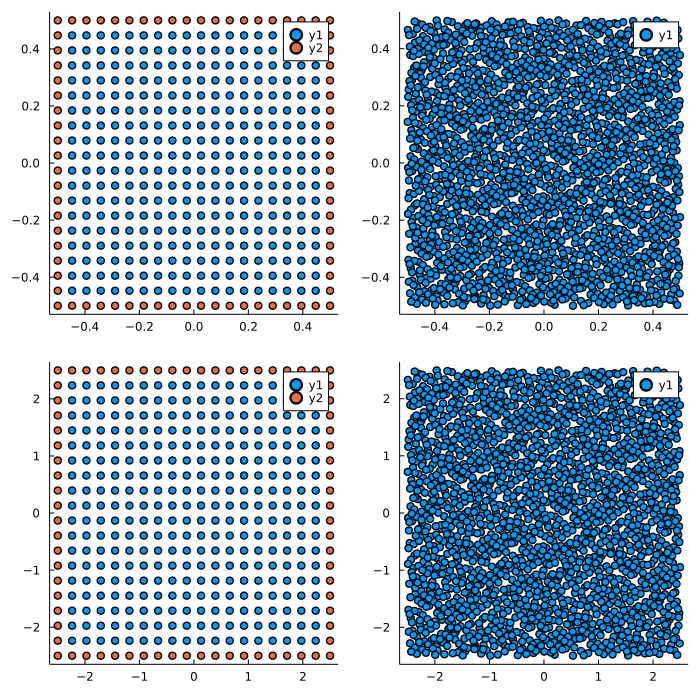

In [136]:
scale = 5
shift = 0.0
N_coll = 20
N_test = 2000
I_points,B_points = generate_2D_equally_spaced_points(N_coll)
I_points = I_points .- 0.5
B_points = B_points .- 0.5
N_I = size(I_points)[2]
N_B = size(B_points)[2]
All_points = hcat(I_points,B_points)
All_points = All_points
#Test_points = hcat(generate_2D_equally_spaced_points(117)...)
Test_points = generate_2D_Halton_points(N_test) .- 0.5
N_tot = size(All_points)[2]

I_points2 = scale*(I_points .- shift)
B_points2 = scale*(B_points .- shift)
Test_points2  = scale*(Test_points .- shift)

l = @layout [a b; c d]
p1 = scatter(I_points[1,:], I_points[2,:])
p1 = scatter!(B_points[1,:], B_points[2,:])

p2 = scatter(Test_points[1,:], Test_points[2,:])

p3 = scatter(I_points2[1,:], I_points2[2,:])
p3 = scatter!(B_points2[1,:], B_points2[2,:])

p4 = scatter(Test_points2[1,:], Test_points2[2,:])

plot(p1, p2, p3, p4 ,layout = l,size = (700,700))

In [137]:

param = 0
E = crete_block_point_tensors([Test_points],[I_points,B_points])
E = generate_block_matrices(KE,E,param)
E = flatten(E)


A = crete_block_point_tensors([I_points,B_points],[I_points,B_points])
A = generate_block_matrices(K,A,param)
A = flatten(A)

E2 = crete_block_point_tensors([Test_points2],[I_points2,B_points2])
E2 = generate_block_matrices(KE,E2,param)
E2 = flatten(E2)


A2 = crete_block_point_tensors([I_points2,B_points2],[I_points2,B_points2])
A2 = generate_block_matrices(K,A2,param)
A2 = flatten(A2)

O = zeros(N_poly,N_poly)

P = generate_P_matrix([I_points,B_points],F_P)
PE = generate_P_matrix([Test_points],F_PE)

P2 = generate_P_matrix([I_points2,B_points2],F_P)
PE2 = generate_P_matrix([Test_points2],F_PE)

M = [A P
    P' O]
Q = [E PE]

M2 = [A2 P2
    P2' O]
Q2 = [E2 PE2]

b = vcat(frankes_func.(I_points[1,:],I_points[2,:]),zeros(N_B+N_poly))
println("cond A: ",cond(A))
println("cond M: ",cond(M))
println("cond A2: ",cond(A2))
println("cond M2: ",cond(M2))
display(P)

cond A: 1.7999272930619946e11
cond M: 1.7999306485593567e11
cond A2: 6.134060307726165e8
cond M2: 1.9968536953712058e9


400×10 Matrix{Float64}:
 0.0   0.0        0.0  2.0          …  -0.894737    -0.894737    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.789474    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.684211    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.578947    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.473684    -2.68421
 0.0   0.0        0.0  2.0          …  -0.894737    -0.368421    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.263158    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.157895    -2.68421
 0.0   0.0        0.0  2.0             -0.894737    -0.0526316   -2.68421
 0.0   0.0        0.0  2.0             -0.894737     0.0526316   -2.68421
 0.0   0.0        0.0  2.0          …  -0.894737     0.157895    -2.68421
 0.0   0.0        0.0  2.0             -0.894737     0.263158    -2.68421
 0.0   0.0        0.0  2.0             -0.894737     0.368421    -2.68421
 ⋮            

In [138]:
sol1 = Q*(M\b)
sol2 = Q2*(M2\b)

println("max difference between original and scaled: ",maximum(abs.(sol1-sol2)))
println(maximum(abs.(sol-sol1)))

max difference between original and scaled: 1.1474796098011184
1.059360730533596


In [142]:
maximum(abs.(M2 - M2'))


2000-element Vector{Float64}:
 1.010085547163631
 0.650060183886017
 0.31787022492873773
 0.49358871026334283
 0.7738786116226862
 0.7273914634139176
 0.5565699539280601
 0.06973140645155856
 0.14543902250850338
 0.9102576269807896
 0.6797528792280929
 0.35582542390535193
 1.0394058619837556
 ⋮
 0.31991076243361777
 1.0462923664322414
 0.3894705241379558
 0.22386713584486162
 1.1412401550644773
 0.3446979868982017
 0.5707948356986839
 0.5824612351679341
 0.07922884141308542
 0.11371493594346978
 0.19886567825069387
 0.139585252203283